In [7]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen

In [8]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore", category=ImportWarning, message=".*AltairImportHook.find_spec() not found; falling back to find_module.*")

In [9]:
adata = anndata.read_h5ad("./human_immune.h5ad")
adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [10]:
## Setting: randomly missing labels
np.random.seed(666)
total_cells = adata.n_obs

# Calculate the number of cells to label
num_labeled = int(0.7 * total_cells)

# Initialize all labels with NaN
semi_labels = pd.Series(np.nan, index=adata.obs.index)

# Randomly select 70% of the indices without replacement
indices = np.random.choice(adata.obs.index, size=num_labeled, replace=False)

# Assign the corresponding 'cell_type' labels to these selected indices
semi_labels.loc[indices] = adata.obs.loc[indices, 'final_annotation']

# Now 'semi_labels' contains 70% known labels and 30% NaN
adata.obs['hard_label'] = semi_labels
#when the method requires fillna, ssSTACAS do not need this filling, but scANVI requires)
adata.obs['hard_label'].fillna("Unknown", inplace=True)
adata.obs['hard_label'] = adata.obs['hard_label'].astype('category')

/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_12072/3193594957.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['CD20+ B cells', 'Monocyte-derived dendritic cells', 'CD20+ B cells', 'CD20+ B cells', 'NKT cells', ..., 'Monocyte-derived dendritic cells', 'CD4+ T cells', 'NK cells', 'CD4+ T cells', 'CD4+ T cells']
Length: 23454
Categories (16, object): ['CD4+ T cells', 'CD8+ T cells', 'CD10+ B cells', 'CD14+ Monocytes', ..., 'NK cells', 'NKT cells', 'Plasma cells', 'Plasmacytoid dendritic cells']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  semi_labels.loc[indices] = adata.obs.loc[indices, 'final_annotation']
/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_12072/3193594957.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change 

In [11]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [12]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

In [13]:
# Save the new_labels column to a CSV file
adata.obs[['hard_label']].to_csv('./hard_label_human_immune_30.csv', index=True)

# scANVI

In [8]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 239/239: 100%|█| 239/239 [10:28<00:00,  2.76s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=239` reached.


Epoch 239/239: 100%|█| 239/239 [10:28<00:00,  2.63s/it, v_num=1, train_loss_step


In [20]:
# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     File ./model_scVI/model.pt already downloaded                                                             


/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [21]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

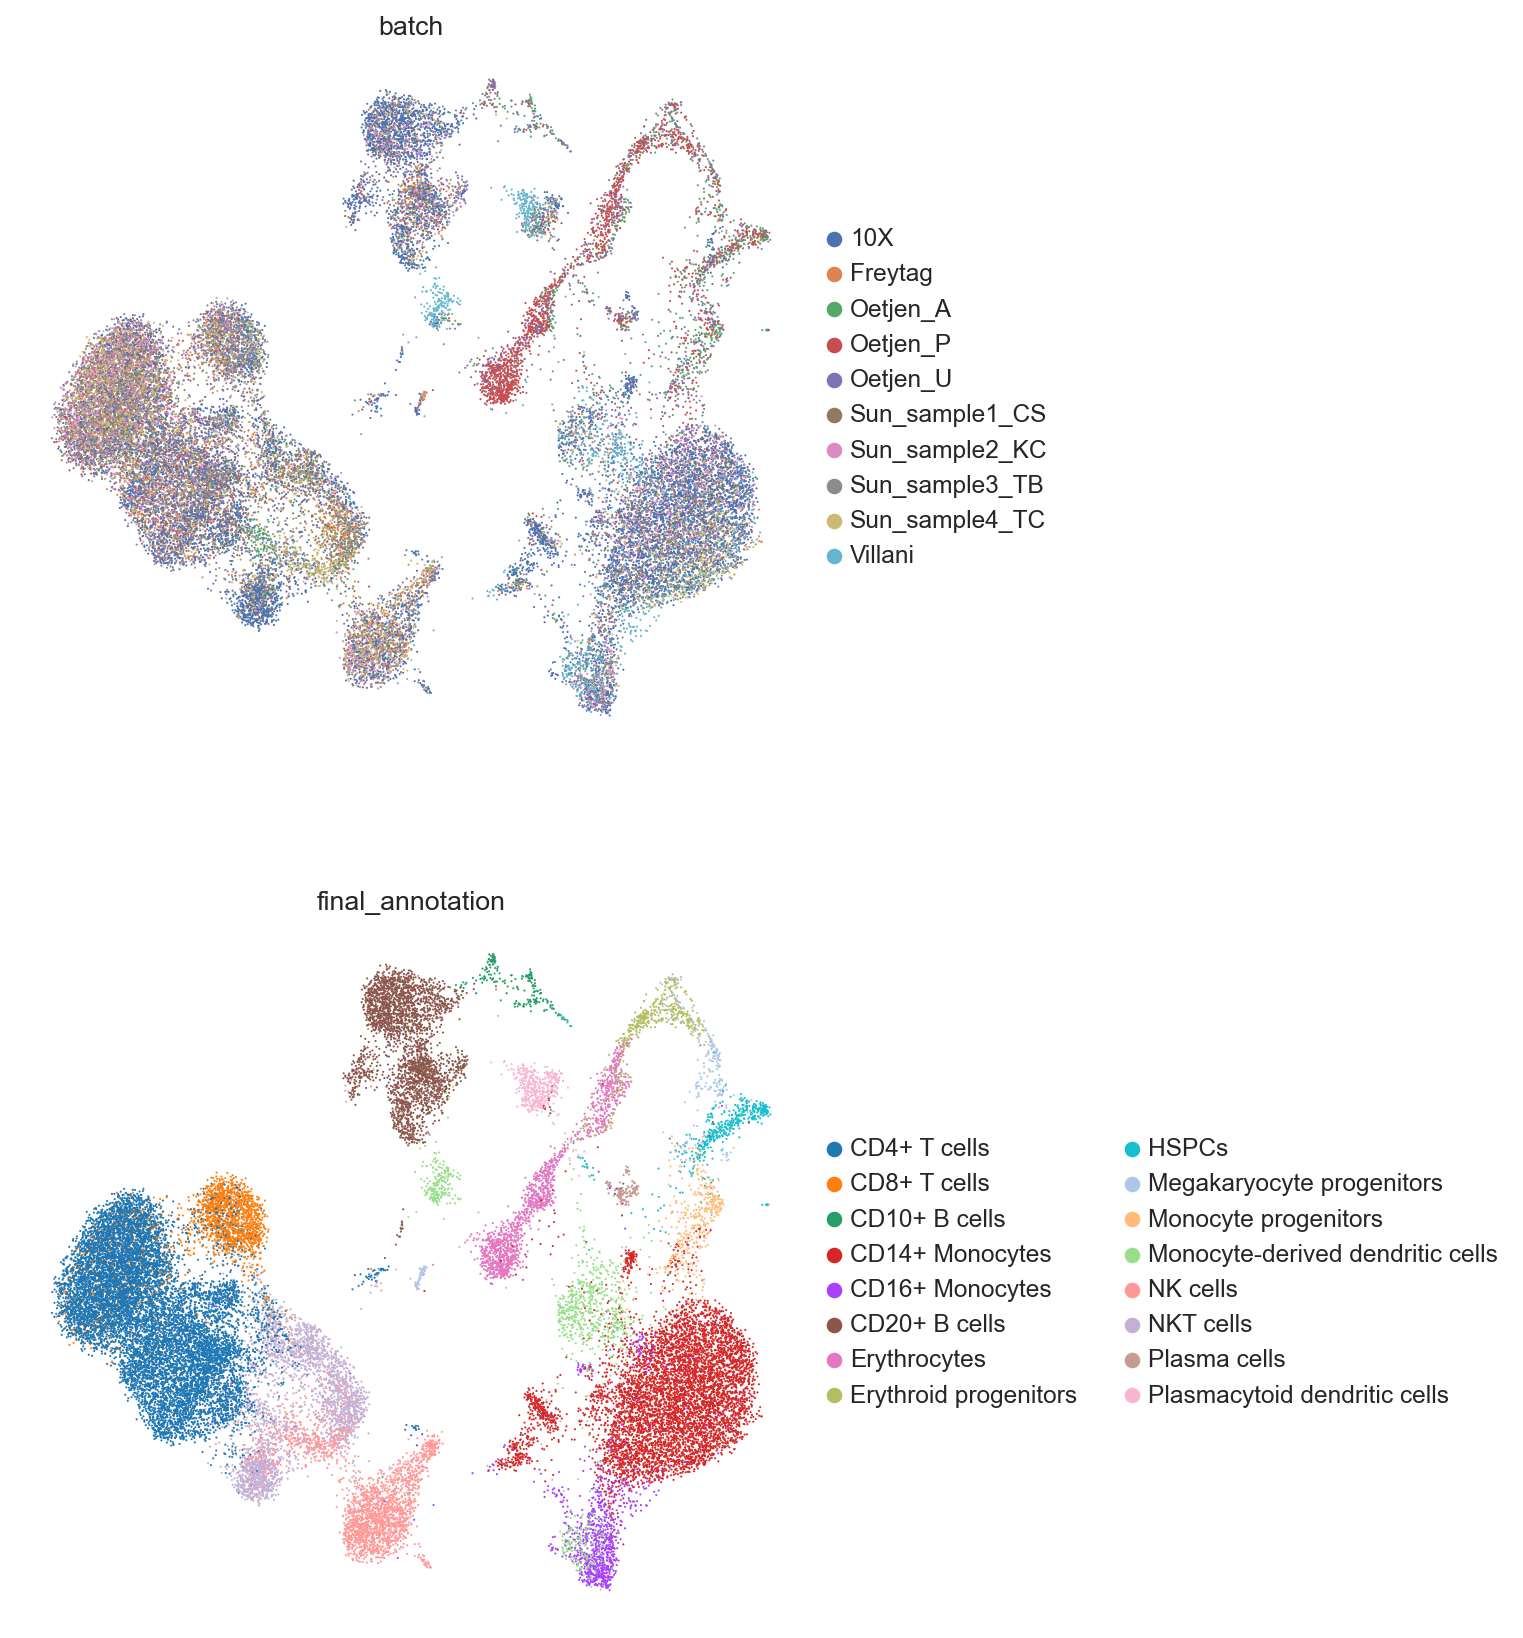

In [24]:
sc.pl.umap(adata, color=["batch", "final_annotation"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [26]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="hard_label",
    unlabeled_category="Unknown",
)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [27]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|█| 20/20 [02:53<00:00,  8.28s/it, v_num=1, train_loss_step=524

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [02:53<00:00,  8.67s/it, v_num=1, train_loss_step=524


In [30]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [31]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [34]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

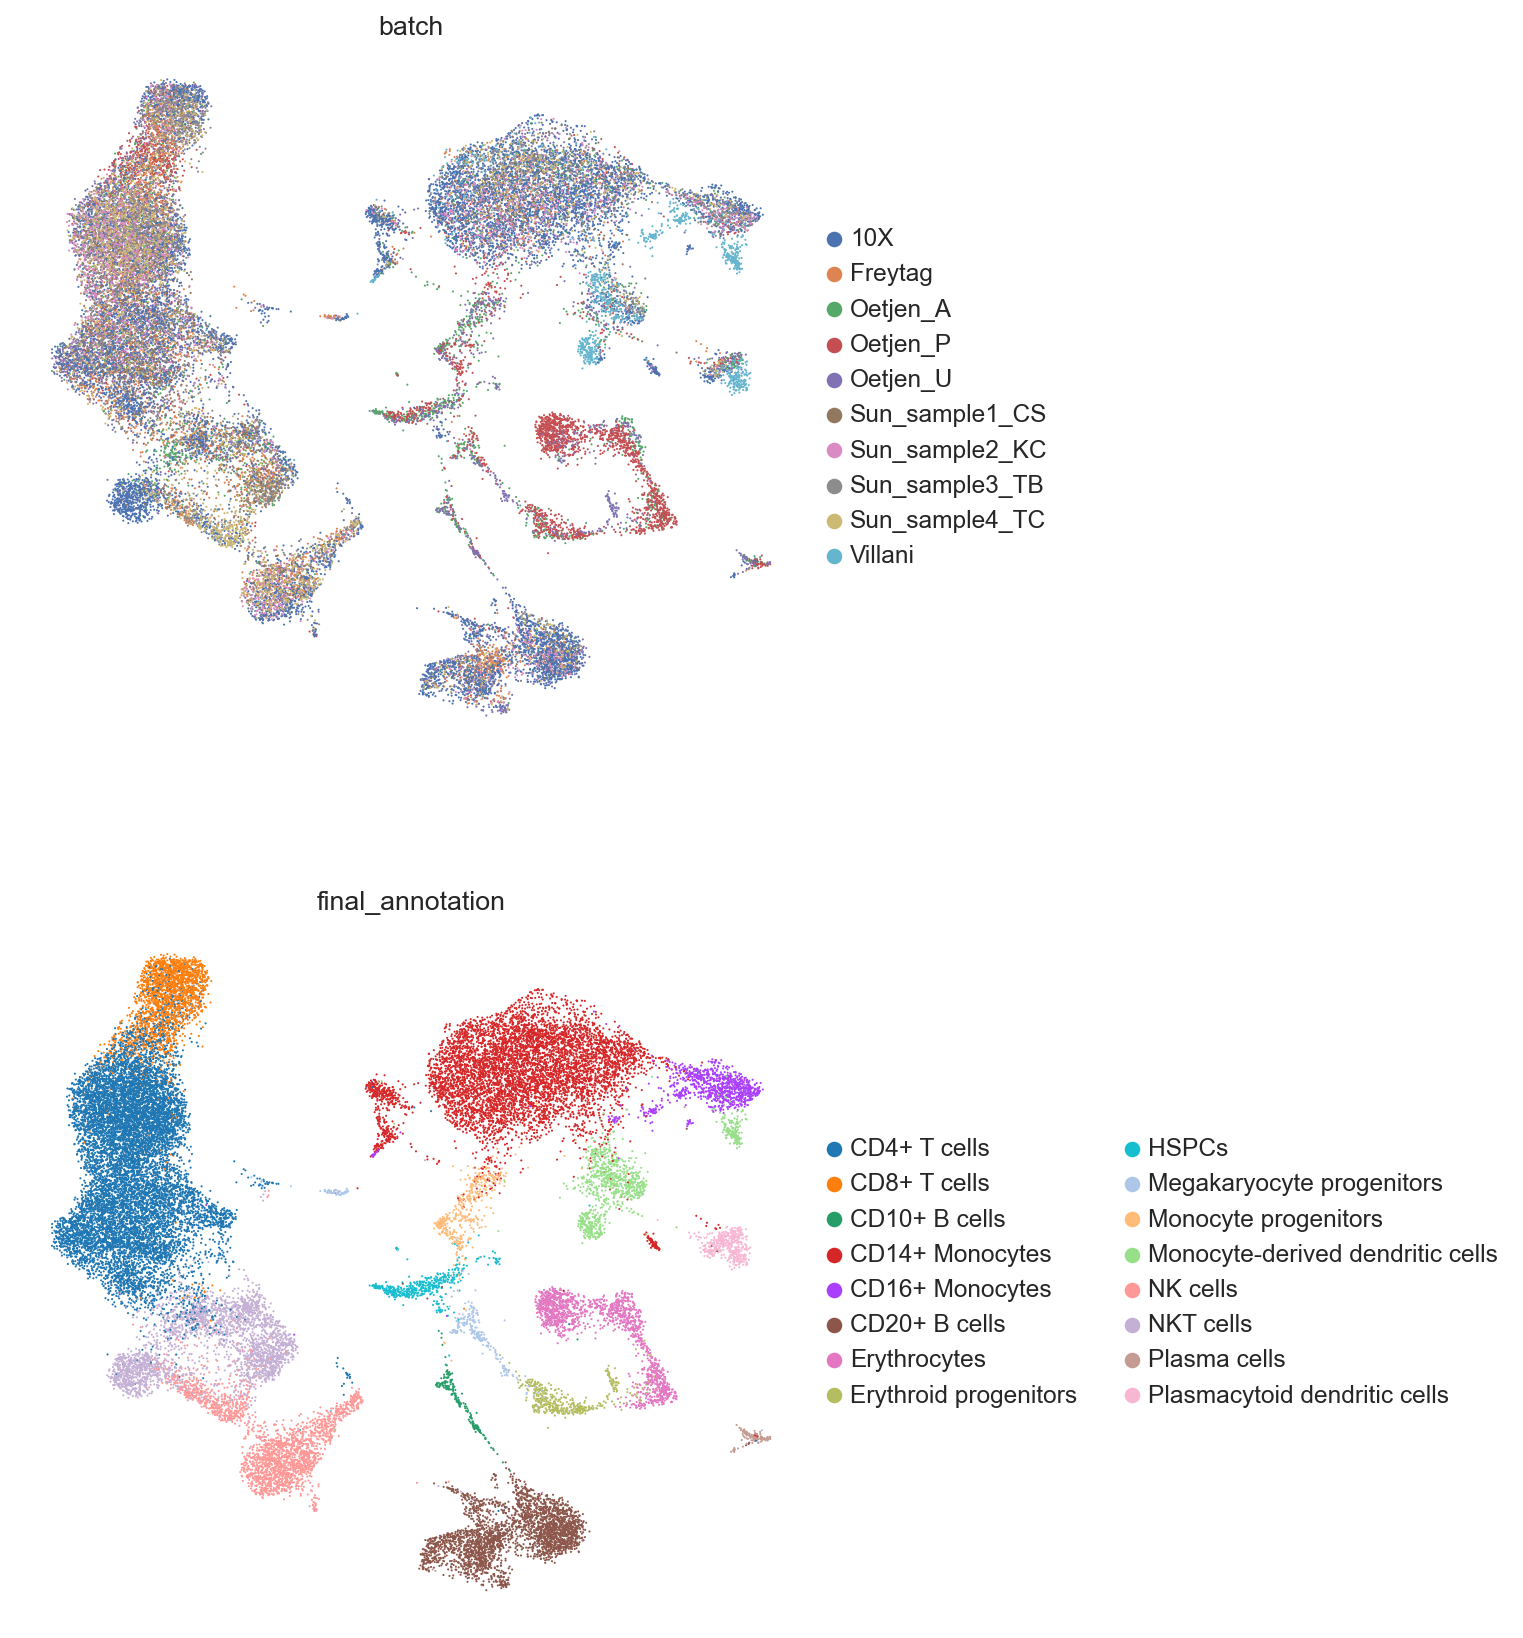

In [35]:
sc.pl.umap(adata, color=["batch", "final_annotation"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "final_annotation" for our batch_removal procedure. There exist a "batch" obs but no "final_annotation", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [38]:
train = adata.copy()

### Preprocessing Data

In [40]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="hard_label")

## Creating and Training the model¶

In [42]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 26/100:  26%|▎| 26/100 [07:34<21:33, 17.48s/it, v_num=1, train_loss_step=2
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1086.523. Signaling Trainer to stop.


## Batch-Removal

In [44]:
corrected_adata = model.batch_removal()
corrected_adata

/opt/anaconda3/lib/python3.12/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 33506 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'hard_label', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [45]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [47]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


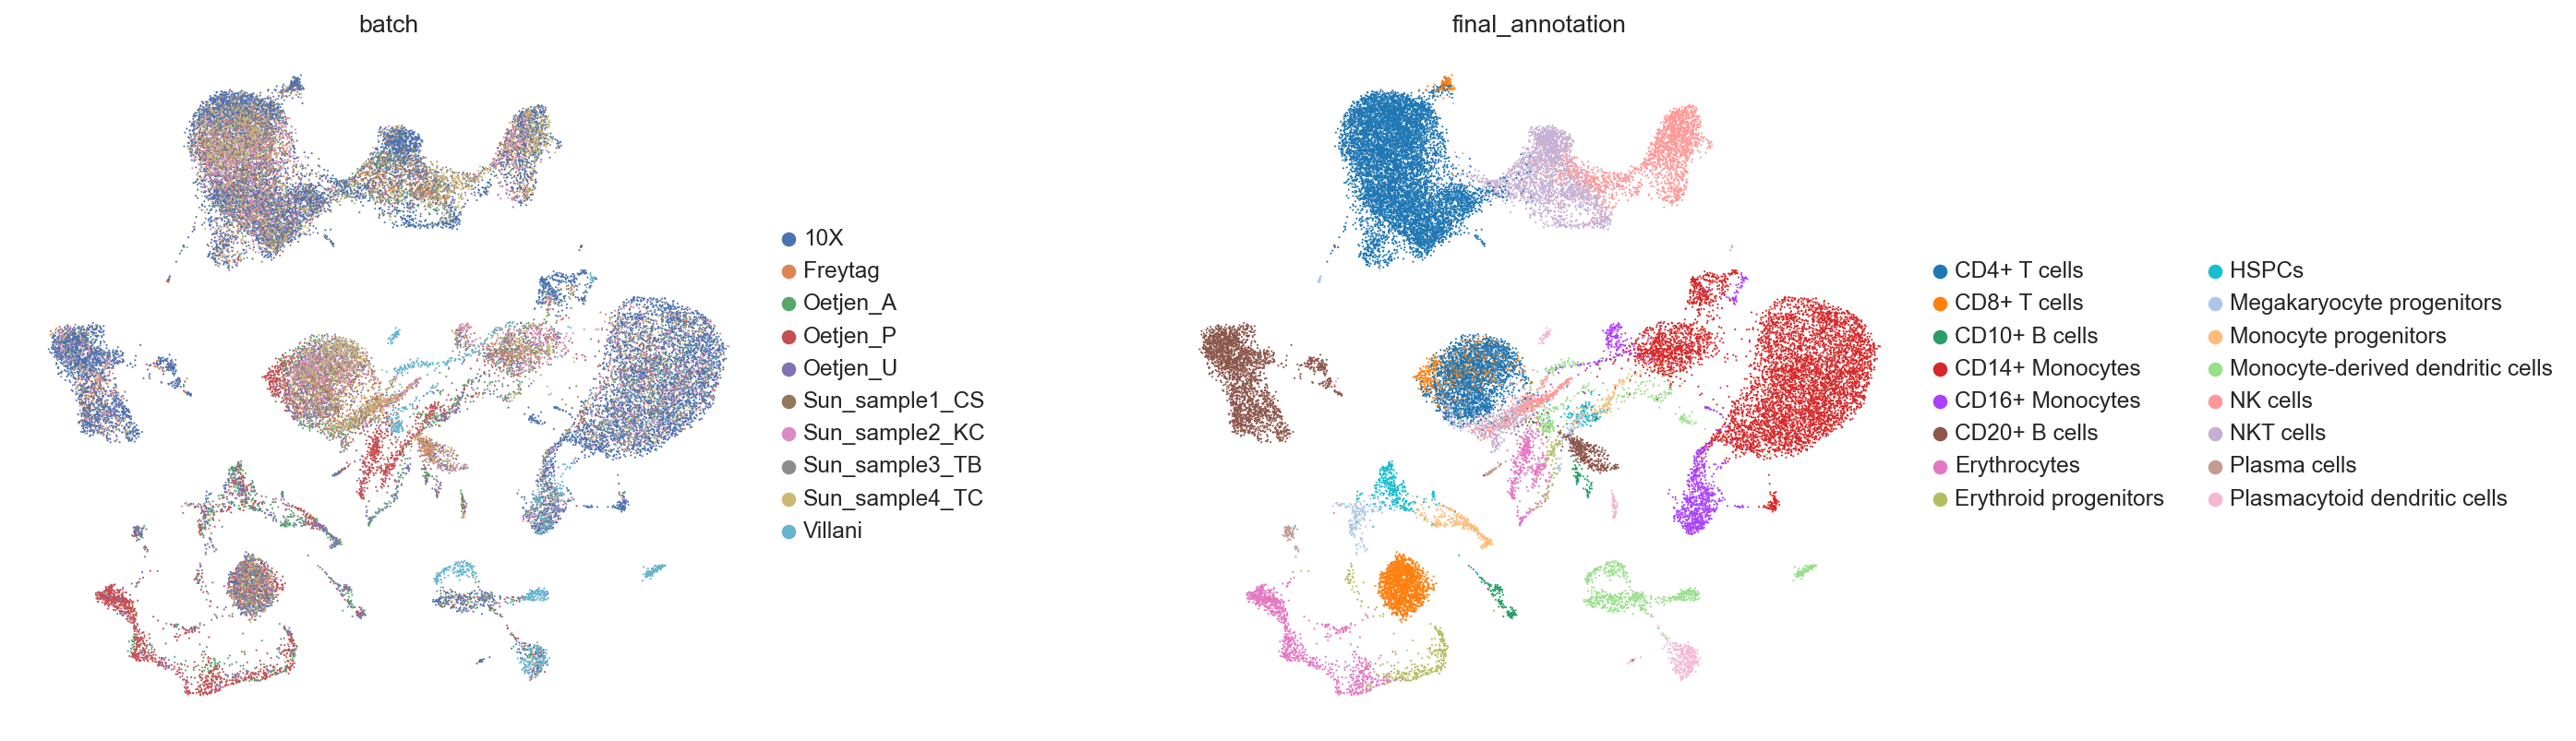

In [48]:
sc.pl.umap(corrected_adata, color=['batch', 'final_annotation'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [51]:
pca_embeddings = pd.read_csv('./human_immune_stacas_embeddings_randomly_missing_labels_30.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [52]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

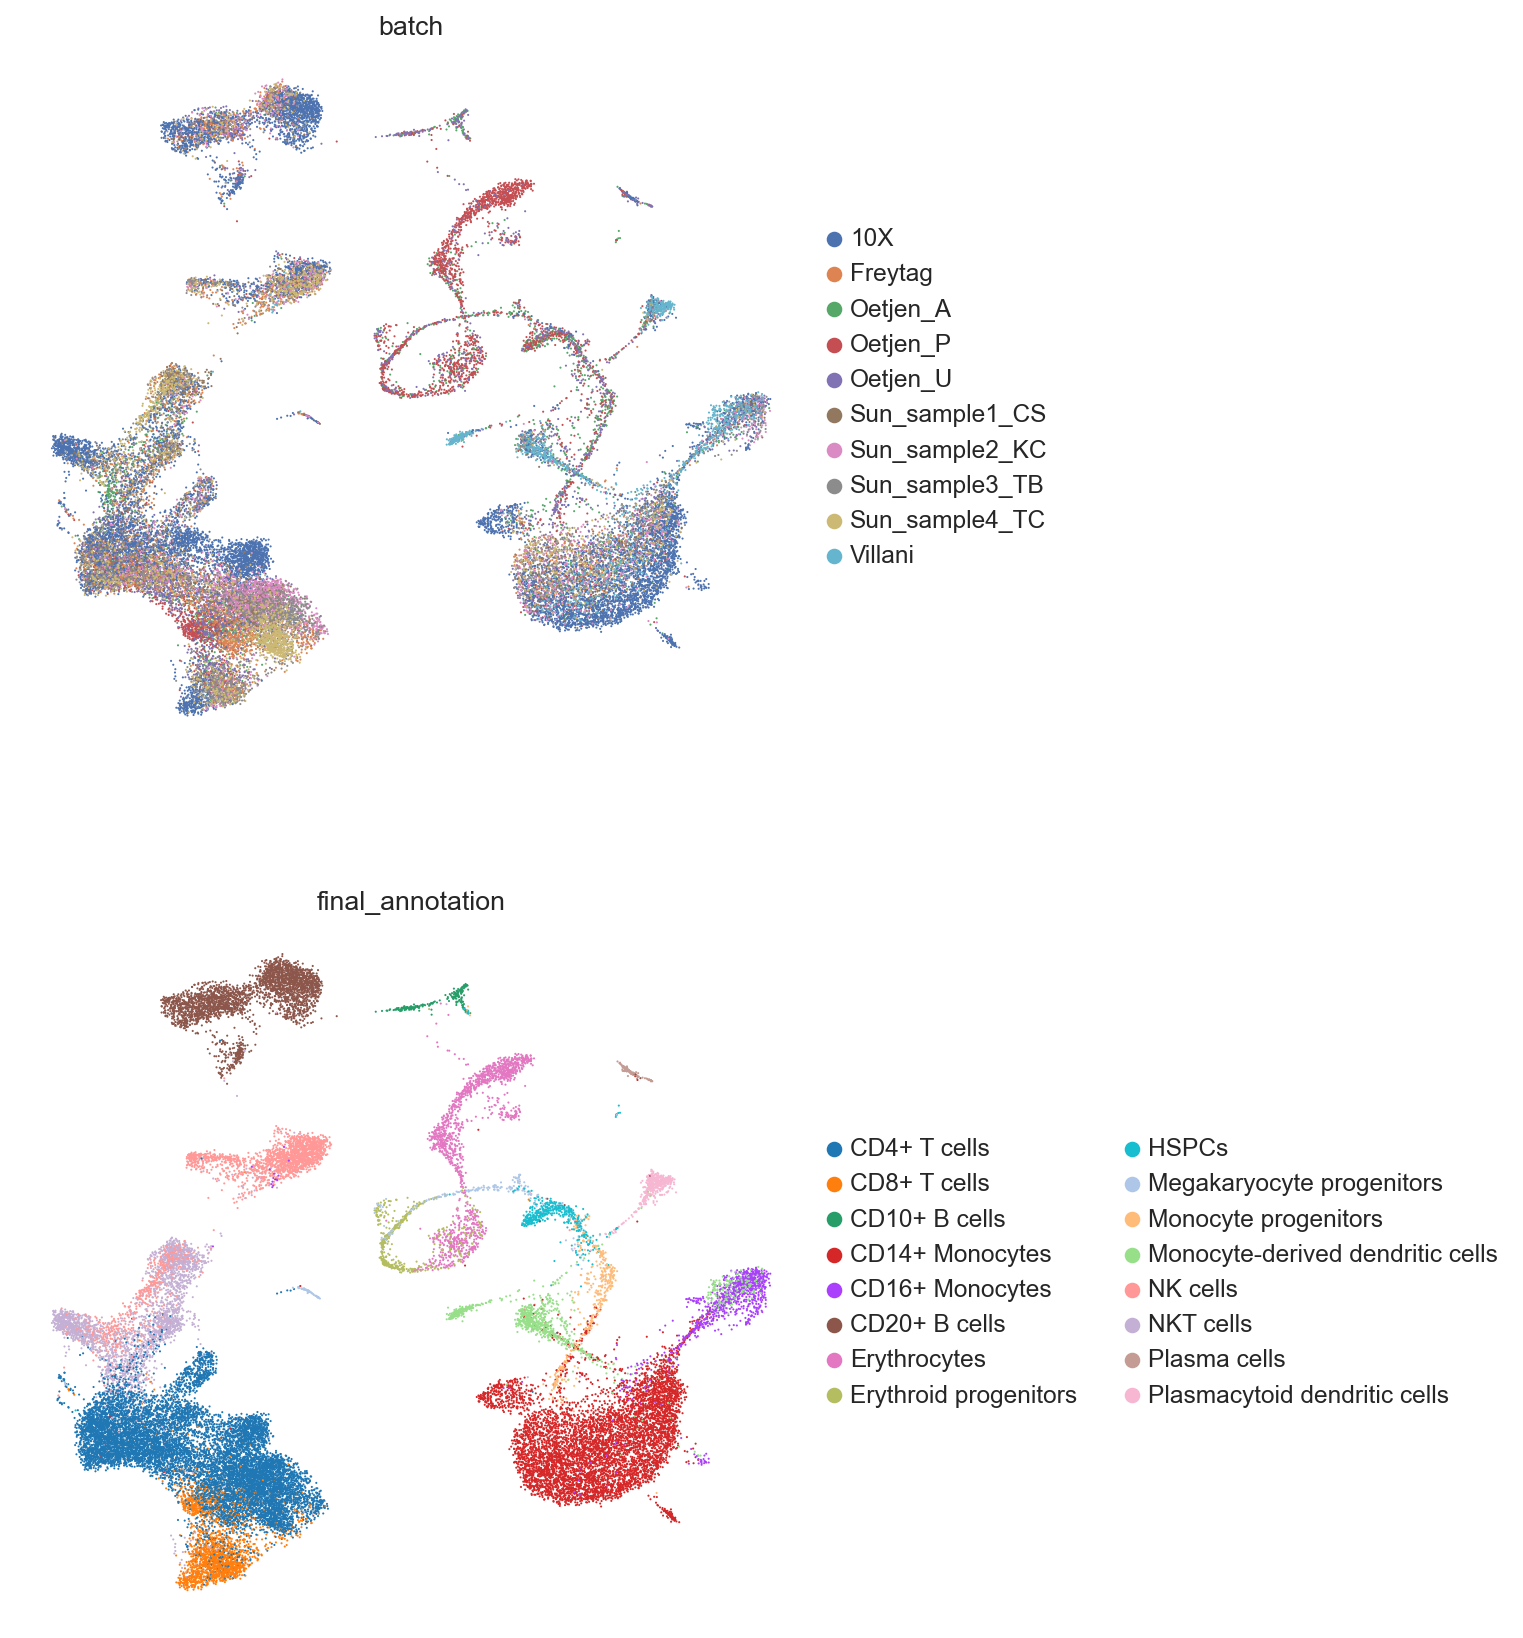

In [53]:
sc.pl.umap(adata, color=["batch", "final_annotation"], frameon=False, ncols=1)

In [54]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("./randomly_missing_human_immune_30.csv")


## Metric Evaluation

In [78]:
# Step 1: Read the CSV file into a DataFrame
import scib
import louvain

combined_embeddings = pd.read_csv("./randomly_missing_human_immune_30.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [79]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df1_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_scANVI')

/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/clustering.py:101: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=cluster_key, **kwargs)


resolution: 0.1, nmi: 0.8256506106503658
resolution: 0.2, nmi: 0.8159443031190878
resolution: 0.3, nmi: 0.819835904922188
resolution: 0.4, nmi: 0.8200770100104985
resolution: 0.5, nmi: 0.8241635955071281
resolution: 0.6, nmi: 0.8084398920914866
resolution: 0.7, nmi: 0.8148273271049373
resolution: 0.8, nmi: 0.7876459642486178
resolution: 0.9, nmi: 0.7848933451441324
resolution: 1.0, nmi: 0.7808940649355327
resolution: 1.1, nmi: 0.7634885148882479
resolution: 1.2, nmi: 0.7687069837194911
resolution: 1.3, nmi: 0.7632325634478145
resolution: 1.4, nmi: 0.756065768200882
resolution: 1.5, nmi: 0.7490306883979735
resolution: 1.6, nmi: 0.7492747713768961
resolution: 1.7, nmi: 0.7327286897030206
resolution: 1.8, nmi: 0.7265203432176766
resolution: 1.9, nmi: 0.7187576830320356
resolution: 2.0, nmi: 0.719026708025888
optimised clustering against final_annotation
optimal cluster resolution: 0.1
optimal score: 0.8256506106503658


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Compute neighbors on rep X_scANVI
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [81]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df2_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_scgen')

resolution: 0.1, nmi: 0.7162189489527213
resolution: 0.2, nmi: 0.7785168398007563
resolution: 0.3, nmi: 0.7732862612395366
resolution: 0.4, nmi: 0.7762488908932319
resolution: 0.5, nmi: 0.7764489262904285
resolution: 0.6, nmi: 0.7573650020781388
resolution: 0.7, nmi: 0.7775087101097676
resolution: 0.8, nmi: 0.7735337467258168
resolution: 0.9, nmi: 0.7633892166267462
resolution: 1.0, nmi: 0.7756452509252632
resolution: 1.1, nmi: 0.7533578883661529
resolution: 1.2, nmi: 0.7484193114974568
resolution: 1.3, nmi: 0.7491384058942109
resolution: 1.4, nmi: 0.7457952078347939
resolution: 1.5, nmi: 0.7463272084906865
resolution: 1.6, nmi: 0.7365107766460299
resolution: 1.7, nmi: 0.7325600696971002
resolution: 1.8, nmi: 0.7257716537277654
resolution: 1.9, nmi: 0.7213849820316255
resolution: 2.0, nmi: 0.719744997421058
optimised clustering against final_annotation
optimal cluster resolution: 0.2
optimal score: 0.7785168398007563


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scgen


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Compute neighbors on rep X_scgen
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [82]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="final_annotation")
df3_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'final_annotation', embed = 'X_stacas')

resolution: 0.1, nmi: 0.8194190845927684
resolution: 0.2, nmi: 0.8046235682736245
resolution: 0.3, nmi: 0.7974670271135452
resolution: 0.4, nmi: 0.7972966703375647
resolution: 0.5, nmi: 0.7836213596519621
resolution: 0.6, nmi: 0.7777490867501767
resolution: 0.7, nmi: 0.7643707737647981
resolution: 0.8, nmi: 0.765947404876258
resolution: 0.9, nmi: 0.7545628598677282
resolution: 1.0, nmi: 0.741426985569432
resolution: 1.1, nmi: 0.7341890537858615
resolution: 1.2, nmi: 0.7300139334816913
resolution: 1.3, nmi: 0.7238356072814388
resolution: 1.4, nmi: 0.7112789976426493
resolution: 1.5, nmi: 0.7044439098905062
resolution: 1.6, nmi: 0.70392582149072
resolution: 1.7, nmi: 0.695837424820569
resolution: 1.8, nmi: 0.6951809048470836
resolution: 1.9, nmi: 0.6912937299370192
resolution: 2.0, nmi: 0.691491743823839
optimised clustering against final_annotation
optimal cluster resolution: 0.1
optimal score: 0.8194190845927684


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_stacas


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Compute neighbors on rep X_stacas
Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [83]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df

scANVI     scGEN    STACAS
NMI_cluster/label          0.858884  0.786906  0.805478
ARI_cluster/label          0.869516  0.707991  0.767702
ASW_label                  0.640061  0.580844  0.598675
ASW_label/batch            0.878666  0.945812  0.899645
PCR_batch                       NaN       NaN       NaN
cell_cycle_conservation         NaN       NaN       NaN
isolated_label_F1          0.936640  0.720625  0.843668
isolated_label_silhouette  0.704780  0.590352  0.649171
graph_conn                 0.992780  0.942832  0.971138
kBET                            NaN       NaN       NaN
iLISI                           NaN       NaN       NaN
cLISI                           NaN       NaN       NaN
hvg_overlap                     NaN       NaN       NaN
trajectory                      NaN       NaN       NaN